# CNN for time series analysis

In [17]:
%pip install tensorflow==2.15

  Using cached tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (3.6 kB)
  Using cached tensorflow_macos-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.2 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
  Using cached wrapt-1.14.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.7 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth_oauthlib-1.2.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cac

In [1]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import pandas as pd
import plotly_express as px
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from functions_laura.Data_processing import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import load_model


![CNN](CNN-wibawa_JBD_2022.png)

### Data normalization

Data normalization is essential for CNN because it can scale the attribute into a specific range required by the activation function. This study uses Min–Max normalization.

## Exponential smoothing with optimum $\alpha$

The smoothed data $ {S}_{t} $ is the result of smoothing the raw data $ {\{X}_{t}\} $. The smoothing factor, $\alpha$ is a value that determines the level of smoothing. The range of $\alpha$ is between 0 and 1 (0 ≤ alpha ≤ 1). When $\alpha$ close to 1, the learning process is fast because it has a less smoothing effect. In contrast, values of $\alpha$ closer to 0 have a more significant smoothing effect and are less responsive to recent changes (slow learning).

How to determine optimum $\alpha$:

$$ Optimum \alpha ={ \alpha }_{max}- \frac{\frac{1}{n} \sum_{t=1}^{n}{ X}_{t}}{{ X}_{ max}- { X}_{ min}} $$


This is the optimum smoothing:

$$ {S}_{t}={ S}_{t-1} +\frac{\left({ X}_{ max}- { X}_{ min}\right)-\frac{1}{n}\sum_{t=1}^{n}{ X}_{t}}{{{X}_{ max}- X}_{ min}}({ X}_{t}-{ S}_{t-1}) $$

## CNN with lucas hidden layers

The input layer used one feature since it is a univariate model. Flatten was used for input to get a fully connected layer. The fully connected layer contains dense for the number of hidden layers.

Instead of using a random number, we used the Lucas number to determine the hidden layer. The Lucas number (Ln) is recursive in the same way as the Fibonacci sequence (Fn), with each term equal to the sum of the two preceding terms, yet with different initial values. This sequence was selected since it provides a golden ratio number. The golden ratio emerges in nature, demonstrating that this enchanted number is ideal for determining the optimal solution to numerous covering problems such as arts, engineering, and financial forecasting. In this study, the Lucas number starts from three and ends with the last number before 100, which is 76. We limited the number of hidden layers to avoid the impact of time consumption and efficiency performance. Overall, we used 3, 4, 7, 11, 18, 29, 47, and 76 [40] for the numbers of hidden layers.

![hidden](Lucas-hidden.png)



loading of the data and creating the needed data from the dataframe

In [2]:
from functions_laura.Data_processing import resample_with_seasonality
from functions_laura.Data_processing import resample
from functions_laura.Data_processing import add_seasonal

In [3]:
df = pd.read_parquet('../data/hamburg_23-25-brands.parquet')


resample the data

In [4]:
# only compute the seasonality on the training data!
resampled_df = resample(df)

train-test split

In [5]:
train_df, test_df = train_test_split(resampled_df)

In [6]:
train_df['datetime'].sort_values()

1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
5        2023-01-01 00:25:00
                 ...        
244796   2025-04-29 23:40:00
244797   2025-04-29 23:45:00
244798   2025-04-29 23:50:00
244799   2025-04-29 23:55:00
244800   2025-04-30 00:00:00
Name: datetime, Length: 244800, dtype: datetime64[ns]

In [7]:
test_df['datetime'].sort_values()

245088   2025-05-01 00:00:00
245089   2025-05-01 00:05:00
245090   2025-05-01 00:10:00
245091   2025-05-01 00:15:00
245092   2025-05-01 00:20:00
                 ...        
251708   2025-05-23 23:40:00
251709   2025-05-23 23:45:00
251710   2025-05-23 23:50:00
251711   2025-05-23 23:55:00
251712   2025-05-24 00:00:00
Name: datetime, Length: 6625, dtype: datetime64[ns]

In [8]:
test_df.columns

Index(['datetime', 'e5'], dtype='object')

In [9]:
train_df_seasonal = add_seasonal(train_df)

In [10]:
train_df_seasonal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244800 entries, 1 to 244800
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   datetime            244800 non-null  datetime64[ns]
 1   seasonal_component  244799 non-null  float64       
 2   e5                  244800 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 7.5 MB


In [11]:
train_df_seasonal = train_df_seasonal[train_df_seasonal['seasonal_component'].notna()]

In [12]:
train_df_seasonal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244799 entries, 1 to 244799
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   datetime            244799 non-null  datetime64[ns]
 1   seasonal_component  244799 non-null  float64       
 2   e5                  244799 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 7.5 MB


Add the training seasonality to the test set

In [13]:
# 2. Get the seasonal patterns from training data
seasonal_patterns = train_df_seasonal[['seasonal_component', 'datetime']]

In [14]:
print("Test DataFrame datetime info:")
test_df.info()
print("\nSeasonal patterns info:")
seasonal_patterns.info()

Test DataFrame datetime info:
<class 'pandas.core.frame.DataFrame'>
Index: 6625 entries, 245088 to 251712
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  6625 non-null   datetime64[ns]
 1   e5        6625 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 155.3 KB

Seasonal patterns info:
<class 'pandas.core.frame.DataFrame'>
Index: 244799 entries, 1 to 244799
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   seasonal_component  244799 non-null  float64       
 1   datetime            244799 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.6 MB


In [15]:
# Take first 288 values (one complete cycle) and repeat
seasonal_pattern = train_df_seasonal['seasonal_component'].iloc[:288].values
test_df['seasonal_component'] = np.tile(seasonal_pattern, len(test_df)//288 + 1)[:len(test_df)]

# Verify no NaNs
print(test_df.isna().sum())

datetime              0
e5                    0
seasonal_component    0
dtype: int64


/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/ipykernel_76967/55129600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['seasonal_component'] = np.tile(seasonal_pattern, len(test_df)//288 + 1)[:len(test_df)]


* training data = train_df_seasonal
* testing data = test_df

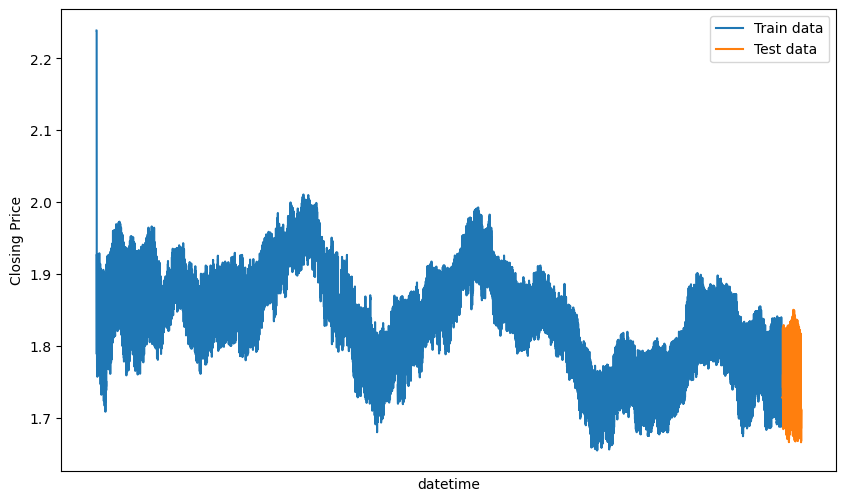

In [16]:
# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('datetime')
plt.ylabel('Closing Price')
plt.xticks([])
plt.plot(train_df_seasonal['e5'], label='Train data')
plt.plot(test_df['e5'], label='Test data')
plt.legend();

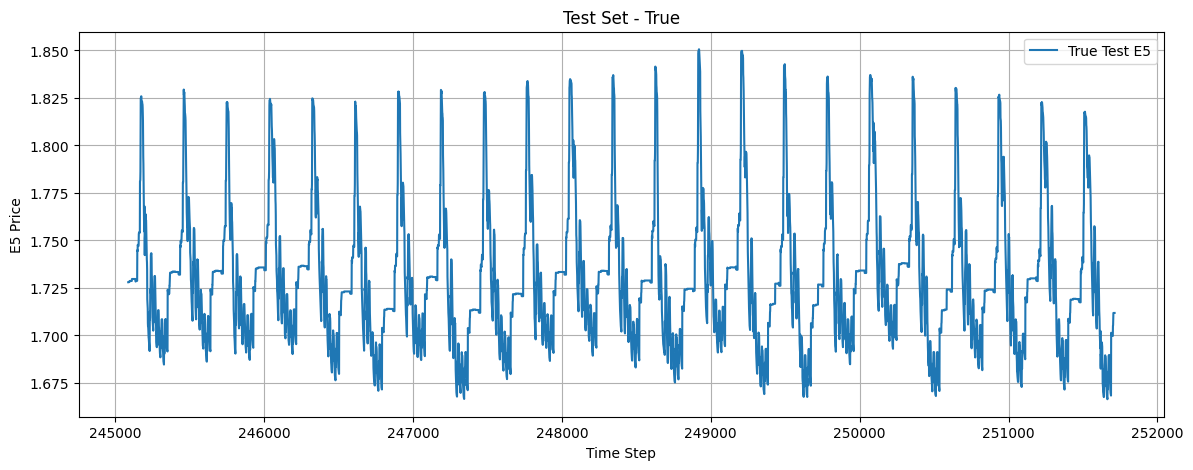

In [17]:
# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df['e5'], label='True Test E5')
plt.title("Test Set - True")
plt.xlabel("Time Step")
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()

we scale the data

In [39]:
scaler = MinMaxScaler()
scaler.fit(train_df_seasonal[['e5', 'seasonal_component']])
scaled_data = scaler.transform(train_df_seasonal[['e5', 'seasonal_component']])
scaled_test = scaler.transform(test_df[['e5', 'seasonal_component']])

In [40]:
scaled_data[:5]

array([[1.        , 0.38379771],
       [1.        , 0.38379937],
       [1.        , 0.38381995],
       [1.        , 0.38386933],
       [1.        , 0.38395035]])

In [41]:
scaled_test[:5]

array([[0.12487   , 0.38379771],
       [0.12487   , 0.38379937],
       [0.12487   , 0.38381995],
       [0.12487   , 0.38386933],
       [0.12487   , 0.38395035]])

### Transforming the data...
so it can fit into my model. We are using a sliding window of 288 (1 day). After every 288 e5 prices, we look at the price that comes after it. 
$X$ is an array consisting of all the sequences, so it has 288 columns.
$y$ is a 1D array of all these values that come after the 288 (= the next step)

$X$ and $y$ have 288 less rows than the original df, because:

| i    | Input `X[i]` (rows used) | Target `y[i]` |
| ---- | ------------------------ | ------------- |
| 0    | rows 0 to 287            | row 288, E5   |
| 1    | rows 1 to 288            | row 289, E5   |
| 2    | rows 2 to 289            | row 290, E5   |
| ...  | ...                      | ...           |
| 9711 | rows 9711 to 9998        | row 9999, E5  |


In [42]:
def create_sequences(data, window_size, target_col_index):
    """Create sequences for time series prediction.
    
    Args:
        data: Scaled input data with shape (samples, features)
        window_size: Number of time steps to look back
        target_col_index: Index of the target column to predict
        
    Returns:
        X: Input sequences with shape (samples, window_size, features)
        y: Target values with shape (samples,)
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        # Get sequence of all features
        sequence = data[i:(i + window_size)]
        X.append(sequence)
        # Get next value of target feature
        target = data[i + window_size, target_col_index]
        y.append(target)
    return np.array(X), np.array(y)

# Create sequences with e5 as target (index 0)
window_size = 288  # one day of 5-min steps
target_col_index = 0  # e5 price is in first column
X, y = create_sequences(scaled_data, window_size, target_col_index)

# Print shapes to verify
print(f"Input shape: {X.shape}")  # Should be (samples, 288, 2)
print(f"Target shape: {y.shape}") # Should be (samples,)

Input shape: (244511, 288, 2)
Target shape: (244511,)


In [23]:
print(X.shape)

(244511, 288, 2)


In [24]:
X[:5]

array([[[1.        , 0.38379771],
        [1.        , 0.38379937],
        [1.        , 0.38381995],
        ...,
        [0.25656593, 0.38226861],
        [0.25656593, 0.38237217],
        [0.26117539, 0.38373264]],

       [[1.        , 0.38379937],
        [1.        , 0.38381995],
        [1.        , 0.38386933],
        ...,
        [0.25656593, 0.38237217],
        [0.26117539, 0.38373264],
        [0.26117539, 0.38379771]],

       [[1.        , 0.38381995],
        [1.        , 0.38386933],
        [1.        , 0.38395035],
        ...,
        [0.26117539, 0.38373264],
        [0.26117539, 0.38379771],
        [0.26117539, 0.38379937]],

       [[1.        , 0.38386933],
        [1.        , 0.38395035],
        [1.        , 0.38425527],
        ...,
        [0.26117539, 0.38379771],
        [0.26117539, 0.38379937],
        [0.26117539, 0.38381995]],

       [[1.        , 0.38395035],
        [1.        , 0.38425527],
        [1.        , 0.38430671],
        ...,
        [

In [25]:
y.shape

(244511,)

In [26]:
y[:5]

array([0.26117539, 0.26117539, 0.26117539, 0.26117539, 0.26117539])

In [43]:
# we create x_test and y_test from our scaled_test data
window_size = 288  # one day of 5-min steps
target_col_index = 0  # assuming e5 is in column 1 of your scaled array

X_test, y_test = create_sequences(scaled_test, window_size, target_col_index)

In [54]:
print(X_test[0]) 


[[0.12487    0.38379771]
 [0.12487    0.38379937]
 [0.12487    0.38381995]
 [0.12487    0.38386933]
 [0.12487    0.38395035]
 [0.12529028 0.38425527]
 [0.12529028 0.38430671]
 [0.12529028 0.38700818]
 [0.12529028 0.39520704]
 [0.12529028 0.39524746]
 [0.12602577 0.39527151]
 [0.12602577 0.40702027]
 [0.12602577 0.40735183]
 [0.12602577 0.40736824]
 [0.12602577 0.40736067]
 [0.12602577 0.40736494]
 [0.12602577 0.40736057]
 [0.12602577 0.40737282]
 [0.12602577 0.40738294]
 [0.12602577 0.40732745]
 [0.12602577 0.40660605]
 [0.12602577 0.40649271]
 [0.12602577 0.40661216]
 [0.12602577 0.41353272]
 [0.12602577 0.41367126]
 [0.12781197 0.41365359]
 [0.12781197 0.41364425]
 [0.12781197 0.41361856]
 [0.12781197 0.4136068 ]
 [0.12781197 0.41359853]
 [0.12781197 0.4135994 ]
 [0.12781197 0.41359668]
 [0.12781197 0.41359091]
 [0.12781197 0.41358439]
 [0.12781197 0.41358007]
 [0.12781197 0.41388133]
 [0.12781197 0.41388326]
 [0.12781197 0.41387535]
 [0.12781197 0.41387206]
 [0.12781197 0.41386756]


In [55]:
print(y_test[0])

0.13348575857879608


In [64]:
print("Scaler mins:", scaler.data_min_)
print("Scaler maxs:", scaler.data_max_)


Scaler mins: [ 1.65510778 -0.04265743]
Scaler maxs: [2.239      0.05311652]


In [66]:
print("Train min:", train_df_seasonal[["e5", "seasonal_component"]].min().values)
print("Train max:", train_df_seasonal[["e5", "seasonal_component"]].max().values)


Train min: [ 1.65510778 -0.04265743]
Train max: [2.239      0.05311652]


In [63]:
# check for overlapping timestamps
train_times = set(train_df.index)
test_times = set(test_df.index)
overlap = train_times.intersection(test_times)
print(f"Overlap: {len(overlap)}")


Overlap: 0


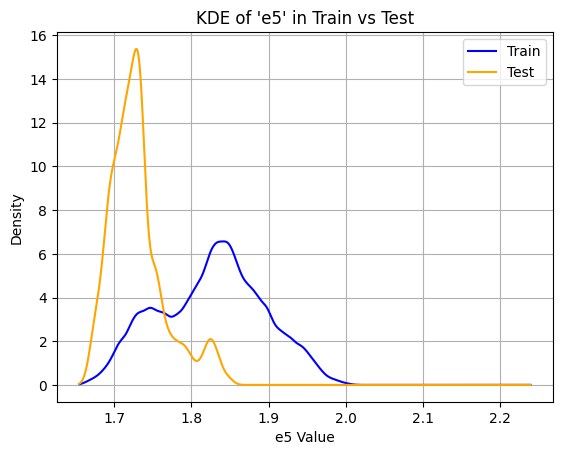

In [62]:
# check distribution of train and test
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

x_train = train_df["e5"].dropna()
x_test = test_df["e5"].dropna()

kde_train = gaussian_kde(x_train)
kde_test = gaussian_kde(x_test)

x_vals = np.linspace(min(x_train.min(), x_test.min()), max(x_train.max(), x_test.max()), 1000)
plt.plot(x_vals, kde_train(x_vals), label='Train', color='blue')
plt.plot(x_vals, kde_test(x_vals), label='Test', color='orange')
plt.legend()
plt.title("KDE of 'e5' in Train vs Test")
plt.xlabel("e5 Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()


In [59]:
print("Scaler mins:", scaler.data_min_)
print("Scaler maxs:", scaler.data_max_)

Scaler mins: [ 1.65510778 -0.04265743]
Scaler maxs: [2.239      0.05311652]


In [28]:
scaled_test.shape

(6625, 2)

In [44]:
y_test.shape

(6337,)

In [31]:

# Example multivariate time-series data
# Assume 'data' is a NumPy array of shape (samples, timesteps, features)
# For instance, data.shape = (1000, 30, 5) for 1000 samples, 30 timesteps, and 5 features

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(288, 2))) # 1-dimensional deconvolution
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # Output layer for forecasting

model.compile(optimizer='adam', loss='mse')

# Fit the model
# Assume 'X_train' and 'y_train' are your training data and labels
# model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

In [32]:
model.fit(X, y, epochs=30, batch_size=32)

Epoch 1/30
7641/7641 [==============================] - 29s 4ms/step - loss: 3.3310e-04
Epoch 2/30
7641/7641 [==============================] - 30s 4ms/step - loss: 4.3550e-05
Epoch 3/30
7641/7641 [==============================] - 30s 4ms/step - loss: 3.1653e-05
Epoch 4/30
7641/7641 [==============================] - 32s 4ms/step - loss: 2.6646e-05
Epoch 5/30
7641/7641 [==============================] - 31s 4ms/step - loss: 2.3605e-05
Epoch 6/30
7641/7641 [==============================] - 31s 4ms/step - loss: 2.2063e-05
Epoch 7/30
7641/7641 [==============================] - 60s 8ms/step - loss: 2.1425e-05
Epoch 8/30
7641/7641 [==============================] - 31s 4ms/step - loss: 2.0683e-05
Epoch 9/30
7641/7641 [==============================] - 32s 4ms/step - loss: 1.9541e-05
Epoch 10/30
7641/7641 [==============================] - 33s 4ms/step - loss: 1.9172e-05
Epoch 11/30
7641/7641 [==============================] - 32s 4ms/step - loss: 1.8877e-05
Epoch 12/30
7641/7641 [=======

save the model

In [33]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
#model.save(f"fuel_price_cnn_model_{timestamp}.h5")
model.save(f"fuel_price_cnn_model_{timestamp}")

INFO:tensorflow:Assets written to: fuel_price_cnn_model_20250606_2252/assets


INFO:tensorflow:Assets written to: fuel_price_cnn_model_20250606_2252/assets


predictions

In [45]:
#model = load_model('../models_laura/fuel_price_cnn_model_20250606_1810') # this one has data leakage from seasonality and train test split
#model = load_model('../models_laura/fuel_price_cnn_model_20250606_2016') # this one has data leakage from train test split
model = load_model('../models_laura/fuel_price_cnn_model_20250606_2252')


# Retrospective model test

In [46]:
y_pred_train = model.predict(X)
y_pred_test = model.predict(X_test)

199/199 [==============================] - 0s 1ms/step


In [47]:
print(y_pred_train.shape)
print(y_pred_test.shape)

(244511, 1)
(6337, 1)


In [48]:
y_pred_train[:5]

array([[0.26489013],
       [0.26454705],
       [0.26436156],
       [0.2678685 ],
       [0.2626869 ]], dtype=float32)

In [67]:
# Use the training set (scaled_data) to get the feature shape
n_features = scaled_data.shape[1]

def inverse_scale(preds, n_features, target_index, scaler):
    dummy = np.zeros((len(preds), n_features))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

# Inverse scaling
y_inv = inverse_scale(y.reshape(-1, 1), n_features, 0, scaler)
y_pred_train_inv = inverse_scale(y_pred_train, n_features, 0, scaler)

y_test_inv = inverse_scale(y_test.reshape(-1, 1), n_features, 0, scaler)
y_pred_test_inv = inverse_scale(y_pred_test, n_features, 0, scaler)


In [68]:
# Get the aligned datetime values - only remove window_size from the start
dt_aligned = test_df['datetime'][window_size:]  # Only offset by window_size at start

# Create DataFrame with matching lengths
# It has a datetime column and the e5 column
y_pred_test_df = pd.DataFrame({
    'datetime': dt_aligned[:len(y_pred_test_inv)],  # Slice to match prediction length
    'e5': y_pred_test_inv
})

# Verify lengths match
print(f"datetime length: {len(dt_aligned[:len(y_pred_test_inv)])}")
print(f"predictions length: {len(y_pred_test_inv)}")

datetime length: 6337
predictions length: 6337


In [73]:
y_pred_test_df.head()

datetime        e5
245376 2025-05-02 00:00:00  1.732822
245377 2025-05-02 00:05:00  1.734991
245378 2025-05-02 00:10:00  1.732430
245379 2025-05-02 00:15:00  1.733781
245380 2025-05-02 00:20:00  1.736268

In [74]:

test_df.iloc[window_size:window_size+5][['datetime']]

datetime
245376 2025-05-02 00:00:00
245377 2025-05-02 00:05:00
245378 2025-05-02 00:10:00
245379 2025-05-02 00:15:00
245380 2025-05-02 00:20:00

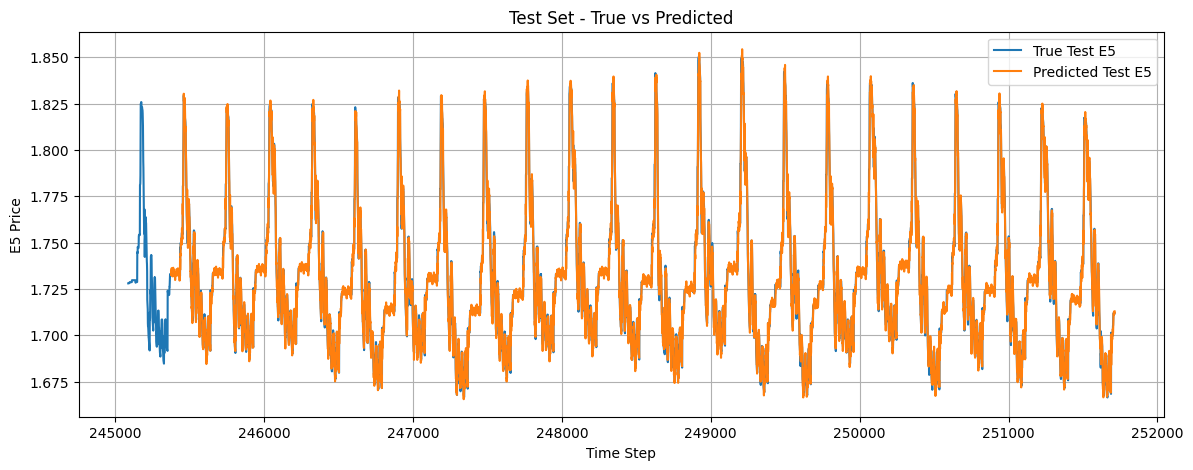

In [69]:
import matplotlib.pyplot as plt

# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df['e5'], label='True Test E5')
plt.plot(y_pred_test_df['e5'], label='Predicted Test E5')
plt.title("Test Set - True vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Combine true and predicted values into one DataFrame for plotting
plot_df = pd.DataFrame({
    "datetime": y_pred_test_df["datetime"],  # aligned datetime
    "True Test E5": y_test_inv.flatten(),
    "Predicted Test E5": y_pred_test_inv.flatten()
})

# Melt the DataFrame to long format for px.line
plot_df_melted = plot_df.melt(id_vars="datetime", 
                              value_vars=["True Test E5", "Predicted Test E5"], 
                              var_name="Type", 
                              value_name="E5 Price")

# Create interactive line plot
fig = px.line(plot_df_melted, 
              x="datetime", 
              y="E5 Price", 
              color="Type", 
              title="Test Set - True vs Predicted")

fig.update_layout(
    width=1800,
    height=800,
    xaxis_title="Datetime",
    yaxis_title="E5 Price"
)

fig.show()


In [71]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Train error
mae_train = mean_absolute_error(y_inv, y_pred_train_inv)
mape_train = mean_absolute_percentage_error(y_inv, y_pred_train_inv)

# Test error
mae_test = mean_absolute_error(y_test_inv, y_pred_test_inv)
mape_test = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)

print(f"Train MAE: {mae_train:.4f}, Train MAPE: {mape_train*100:.2f}%")
print(f"Test MAE: {mae_test:.4f}, Test MAPE: {mape_test*100:.2f}%")


Train MAE: 0.0014, Train MAPE: 0.07%
Test MAE: 0.0033, Test MAPE: 0.19%


# Real forecasting use case
## we only use the first seven days of the test set to predict the last 15 days retrospectively

In [82]:
# Parameters
window_size = 288
forecast_steps = 15 * 288  # Predict 15 days at 5-min intervals

# Step 1: Prepare initial input window (first 7 days)
initial_input = test_df.iloc[:7*288].copy()
initial_scaled = scaler.transform(initial_input[['e5', 'seasonal_component']])

# Step 2: Rolling forecast
rolling_window = list(initial_scaled)  # start with list for easy appending
predictions_scaled = []

for step in range(forecast_steps):
    # Prepare current input window
    current_input = np.array(rolling_window[-window_size:])  # (288, 2)
    current_input = current_input.reshape(1, window_size, 2)  # shape: (1, 288, 2)

    # Predict next step
    pred_scaled = model.predict(current_input, verbose=0)  # shape: (1, 1)

    # Build the full next input row (2 features)
    # Seasonal component for the next time step is taken from test_df
    seasonal_next = test_df.iloc[7*288 + step]['seasonal_component']
    
    # Append prediction + known seasonal component
    next_input_row = [pred_scaled[0][0], seasonal_next]
    rolling_window.append(next_input_row)

    # Store predicted value
    predictions_scaled.append(next_input_row)

# Step 3: Inverse transform predictions
pred_array = np.array(predictions_scaled)
inv = scaler.inverse_transform(pred_array)
e5_predictions = inv[:, 0]

# Step 4: Get true values for comparison
true_e5 = test_df.iloc[7*288:]['e5'].values[:forecast_steps]
datetime_vals = test_df.iloc[7*288:]['datetime'].values[:forecast_steps]

aligned_dt = test_df['datetime'][window_size:window_size + len(y_pred_test_inv)]

results_df = pd.DataFrame({
    "datetime": aligned_dt.values,
    "True E5": test_df['e5'][window_size:window_size + len(y_pred_test_inv)].values,
    "Predicted E5": y_pred_test_inv.flatten()
})
results_df.head()

datetime   True E5  Predicted E5
0 2025-05-02 00:00:00  1.733049      1.732822
1 2025-05-02 00:05:00  1.733049      1.734991
2 2025-05-02 00:10:00  1.733049      1.732430
3 2025-05-02 00:15:00  1.733233      1.733781
4 2025-05-02 00:20:00  1.733233      1.736268

In [80]:
print("results_df shape:", results_df.shape)
print("Min E5:", results_df['True E5'].min(), "Pred E5:", results_df['Predicted E5'].min())
print("Max E5:", results_df['True E5'].max(), "Pred E5:", results_df['Predicted E5'].max())

results_df shape: (4320, 3)
Min E5: 1.66660736196319 Pred E5: 1.6636697421848754
Max E5: 1.8506564417177913 Pred E5: 1089178507361351.4


In [81]:
print("NaNs in Predicted E5:", results_df['Predicted E5'].isna().sum())
print("Zero values in Predicted E5:", (results_df['Predicted E5'] == 0).sum())

NaNs in Predicted E5: 0
Zero values in Predicted E5: 0


In [83]:
plot_df = results_df.melt(id_vars="datetime", 
                          value_vars=["True E5", "Predicted E5"],
                          var_name="Type", value_name="E5 Price")

fig = px.line(plot_df, x="datetime", y="E5 Price", color="Type",
              title="True Forecast vs. Rolling Prediction (15 days)")

fig.update_layout(width=1600, height=700)
fig.show()

In [84]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=results_df['datetime'], 
                         y=results_df['True E5'],
                         mode='lines',
                         name='True E5'))

fig.add_trace(go.Scatter(x=results_df['datetime'], 
                         y=results_df['Predicted E5'],
                         mode='lines',
                         name='Predicted E5'))

fig.update_layout(title="True vs. Predicted E5 Prices (Rolling Forecast)",
                  xaxis_title="Datetime",
                  yaxis_title="E5 Price",
                  width=1600,
                  height=700)

fig.show()

# we try again, the above was weird..

In [89]:
# You must cut your test set like this:

test_start = pd.to_datetime("2025-05-01")
test_end = pd.to_datetime("2025-05-24")

first_7_days = test_df[(test_df["datetime"] >= test_start) & 
                       (test_df["datetime"] < test_start + pd.Timedelta(days=7))]



In [93]:
first_7_days.head()

datetime        e5  seasonal_component
245088 2025-05-01 00:00:00  1.728018           -0.005900
245089 2025-05-01 00:05:00  1.728018           -0.005899
245090 2025-05-01 00:10:00  1.728018           -0.005897
245091 2025-05-01 00:15:00  1.728018           -0.005893
245092 2025-05-01 00:20:00  1.728018           -0.005885

In [94]:
# You use only these first 7 days (7 × 288 = 2016 samples) to form the initial sliding window input:
input_seq = first_7_days[["e5", "seasonal_component"]]
input_scaled = scaler.transform(input_seq)

In [97]:
%pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [101]:
# Then you run auto-regressive prediction:
from tqdm import tqdm

# Define constants
window_size = 288
forecast_days = 17
steps_to_predict = forecast_days * 288
target_index = 0  # Assuming 'e5' is the first column in scaling

# You must cut your test set like this:

test_start = pd.to_datetime("2025-05-01")
test_end = pd.to_datetime("2025-05-24")

first_7_days = test_df[(test_df["datetime"] >= test_start) & 
                       (test_df["datetime"] < test_start + pd.Timedelta(days=7))]

# You use only these first 7 days (7 × 288 = 2016 samples) to form the initial sliding window input:
input_seq = first_7_days[["e5", "seasonal_component"]]
input_scaled = scaler.transform(input_seq)


# 2. Initialize sliding window with last 288 time steps (one day)
last_window = input_scaled[-window_size:].copy()

In [ ]:
# 3. Autoregressive prediction
predictions_scaled = []
start_index = len(first_7_days)  # Starting point (after first 7 days)

all_seasonal = test_df["seasonal_component"].values
seasonal_pattern_length = 288  # One day pattern

for _ in tqdm(range(steps_to_predict)):
    input_window = last_window.reshape(1, window_size, -1)  # shape: (1, 288, 2)
    
    # Predict next step
    next_pred_scaled = model.predict(input_window, verbose=0)[0, 0]  # shape: scalar

    # Get seasonal component by wrapping around the daily pattern
    seasonal_idx = (start_index + step) % seasonal_pattern_length
    next_seasonal = all_seasonal[seasonal_idx]
    
    # Create properly formatted input for scaler
    next_seasonal_scaled = scaler.transform([[0, next_seasonal]])[0, 1]
    
    next_input = np.zeros((2,))
    next_input[target_index] = next_pred_scaled
    next_input[1 - target_index] = next_seasonal_scaled

    # Append prediction and slide window
    predictions_scaled.append(next_input[target_index])
    last_window = np.vstack([last_window[1:], next_input])
    

  0%|          | 0/4896 [00:00<?, ?it/s]/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

  0%|          | 2/4896 [00:00<04:26, 18.33it/s]/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning

In [ ]:

# 4. Inverse transform predictions
def inverse_scale(preds, original_data, target_index, scaler):
    dummy = np.zeros((len(preds), original_data.shape[1]))
    dummy[:, target_index] = preds
    return scaler.inverse_transform(dummy)[:, target_index]

preds_inv = inverse_scale(np.array(predictions_scaled), input_scaled, target_index, scaler)

# 5. Create datetime index
forecast_start = pd.to_datetime("2025-05-08 00:00")
pred_datetimes = pd.date_range(start=forecast_start, periods=steps_to_predict, freq="5min")

In [108]:
# 6. Create results DataFrame for predicted values (from 08.05.)
results_df = pd.DataFrame({
    "datetime": pred_datetimes,
    "Predicted E5": preds_inv
})

# 7. Get true values from entire test period (from 01.05.)
true_values = test_df[["datetime", "e5"]].copy()

# 8. Merge with predicted values using outer join to keep full time range
comparison_df = pd.merge(true_values, results_df, on="datetime", how="left")

# 9. Plot: true values from 01.05., predicted values only from 08.05.
import plotly.express as px

fig = px.line(comparison_df, x="datetime", y=["e5", "Predicted E5"],
              labels={"value": "E5 Price", "variable": "Type"},
              title="True vs Autoregressive Forecast (Predictions from 08.05.)")

fig.update_layout(width=1600, height=600)
fig.show()


In [107]:
# Forecast error using the comparison_df that contains true and predicted values
mae_forecast = mean_absolute_error(comparison_df['e5'], comparison_df['Predicted E5'])
mape_forecast = mean_absolute_percentage_error(comparison_df['e5'], comparison_df['Predicted E5'])

print(f"Forecast MAE: {mae_forecast:.4f}, Forecast MAPE: {mape_forecast*100:.2f}%")

Forecast MAE: 0.0397, Forecast MAPE: 2.26%


The metrics are still good, since the value range is small! But we need to see how well our prediction follows the shape

### Metrics, to see how well the shape is followed

<Axes: title={'center': 'Residuals (True - Predicted)'}>

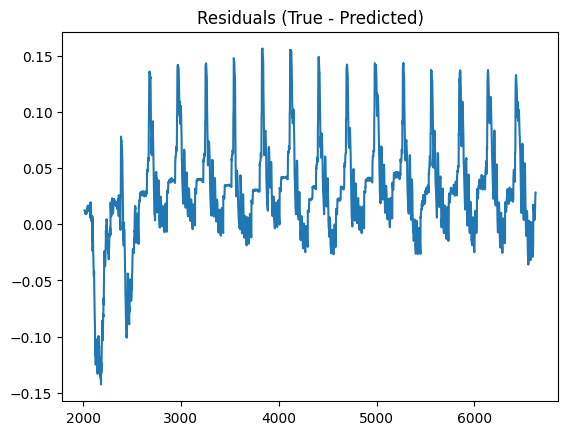

In [116]:
comparison_df["residual"] = comparison_df["e5"] - comparison_df["Predicted E5"]
comparison_df["residual"].plot(title="Residuals (True - Predicted)")


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

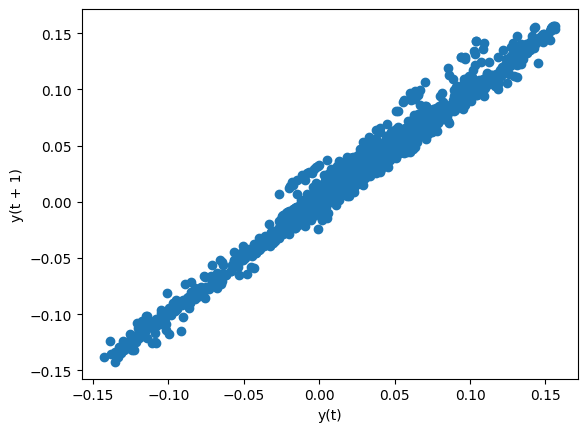

In [119]:
pd.plotting.lag_plot(comparison_df["residual"])

In [121]:
%pip install dtw

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'dtw' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'dtw'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5299 sha256=4239308c4db9137d5a33adff1597a1c9a743f52c3d4564e28a3490b77e78f7f4
  Stored in directory: /Users/laurabrylka/Library/Caches/pip/wheels/2c/16/01/ffea89493a0fcd29934418eb0bf10161470acf8d5647bab656
Successfully built dtw
Note: you may need to restart the kernel to use updated packages.


In [123]:
from dtw import dtw
import numpy as np

# Convert to numpy arrays and drop NaN values
mask = ~(np.isnan(comparison_df["e5"]) | np.isnan(comparison_df["Predicted E5"]))
x = comparison_df["e5"][mask].values
y = comparison_df["Predicted E5"][mask].values

# Define distance function (Manhattan)
manhattan_distance = lambda x, y: np.abs(x - y)

# Compute DTW - returns (distance, cost_matrix, acc_cost_matrix, path)
d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=manhattan_distance)

print(f"DTW distance: {d}")

DTW distance: 109.10418200128848


Let me explain the DTW (Dynamic Time Warping) distance value:

The DTW distance of 109.10 represents the cumulative distance between your true and predicted E5 price sequences after finding the optimal alignment between them. 

Key points about this value:
1. It measures shape similarity between the two time series
2. Lower values indicate better matching of patterns
3. The value is in the same units as your E5 prices (euros/cents)
4. It accounts for temporal shifts/warping between the sequences

To put this value in context, you should:
1. Compare it to your data range (max-min of E5 prices)
2. Normalize it by sequence length to get average per-point distance
3. Compare it with other models' DTW scores


In [124]:
seq_length = len(x)
price_range = np.max(x) - np.min(x)
avg_dtw_dist = d / seq_length

print(f"Sequence length: {seq_length}")
print(f"Price range: {price_range:.4f}")
print(f"DTW distance: {d:.4f}")
print(f"Average DTW distance per point: {avg_dtw_dist:.4f}")
print(f"DTW distance as % of price range: {(d/price_range)*100:.2f}%")

Sequence length: 4609
Price range: 0.1842
DTW distance: 109.1042
Average DTW distance per point: 0.0237
DTW distance as % of price range: 59232.39%


# less input for prediction

In [134]:
# Then you run auto-regressive prediction:
# Define constants
window_size = 288
forecast_days = 1
steps_to_predict = forecast_days * 288
target_index = 0  # Assuming 'e5' is the first column in scaling

# You must cut your test set like this:

test_start = pd.to_datetime("2025-05-01")
test_end = pd.to_datetime("2025-05-24")

first_7_days = test_df[(test_df["datetime"] >= test_start) & 
                       (test_df["datetime"] < test_start + pd.Timedelta(days=14))]

# You use only these first 7 days (7 × 288 = 2016 samples) to form the initial sliding window input:
input_seq = first_7_days[["e5", "seasonal_component"]]
input_scaled = scaler.transform(input_seq)


# 2. Initialize sliding window with last 288 time steps (one day)
last_window = input_scaled[-window_size:].copy()

In [135]:
# 3. Autoregressive prediction
predictions_scaled = []
start_index = len(first_7_days)  # Starting point (after first 7 days)

all_seasonal = test_df["seasonal_component"].values
seasonal_pattern_length = 288  # One day pattern

for _ in tqdm(range(steps_to_predict)):
    input_window = last_window.reshape(1, window_size, -1)  # shape: (1, 288, 2)
    
    # Predict next step
    next_pred_scaled = model.predict(input_window, verbose=0)[0, 0]  # shape: scalar

    # Get seasonal component by wrapping around the daily pattern
    seasonal_idx = (start_index + step) % seasonal_pattern_length
    next_seasonal = all_seasonal[seasonal_idx]
    
    # Create properly formatted input for scaler
    next_seasonal_scaled = scaler.transform([[0, next_seasonal]])[0, 1]
    
    next_input = np.zeros((2,))
    next_input[target_index] = next_pred_scaled
    next_input[1 - target_index] = next_seasonal_scaled

    # Append prediction and slide window
    predictions_scaled.append(next_input[target_index])
    last_window = np.vstack([last_window[1:], next_input])
    

  0%|          | 0/288 [00:00<?, ?it/s]/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

  1%|          | 2/288 [00:00<00:17, 16.55it/s]/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:


In [137]:

# 4. Inverse transform predictions
def inverse_scale(preds, original_data, target_index, scaler):
    dummy = np.zeros((len(preds), original_data.shape[1]))
    dummy[:, target_index] = preds
    return scaler.inverse_transform(dummy)[:, target_index]

preds_inv = inverse_scale(np.array(predictions_scaled), input_scaled, target_index, scaler)

# 5. Create datetime index
forecast_start = pd.to_datetime("2025-05-15 00:00")
pred_datetimes = pd.date_range(start=forecast_start, periods=steps_to_predict, freq="5min")

In [138]:
# 6. Create results DataFrame for predicted values (from 08.05.)
results_df = pd.DataFrame({
    "datetime": pred_datetimes,
    "Predicted E5": preds_inv
})

# 7. Get true values from entire test period (from 01.05.)
true_values = test_df[["datetime", "e5"]].copy()

# 8. Merge with predicted values using outer join to keep full time range
comparison_df = pd.merge(true_values, results_df, on="datetime", how="left")

# 9. Plot: true values from 01.05., predicted values only from 08.05.
import plotly.express as px

fig = px.line(comparison_df, x="datetime", y=["e5", "Predicted E5"],
              labels={"value": "E5 Price", "variable": "Type"},
              title="True vs Autoregressive Forecast (Predictions from 08.05.)")

fig.update_layout(width=1600, height=600)
fig.show()


In [139]:
# Forecast error using the comparison_df that contains true and predicted values
mae_forecast = mean_absolute_error(comparison_df['e5'], comparison_df['Predicted E5'])
mape_forecast = mean_absolute_percentage_error(comparison_df['e5'], comparison_df['Predicted E5'])

print(f"Forecast MAE: {mae_forecast:.4f}, Forecast MAPE: {mape_forecast*100:.2f}%")

ValueError: Input contains NaN.